In [1]:
import pandas as pd
import numpy as np

loadData = pd.read_csv("eeg_data.csv")
data = np.array(loadData)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

# Define sampling frequency
sf = 128.

def rawEEGplot(data, channelName):
    # time vector
    time = np.arange(data.size) / sf

    # Plot the signal
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    plt.plot(time, data, lw=1.5, color='k')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Voltage')
    plt.xlim([time.min(), time.max()])
    plt.title('Raw EEG at (' + channelName + ')')
    sns.despine()

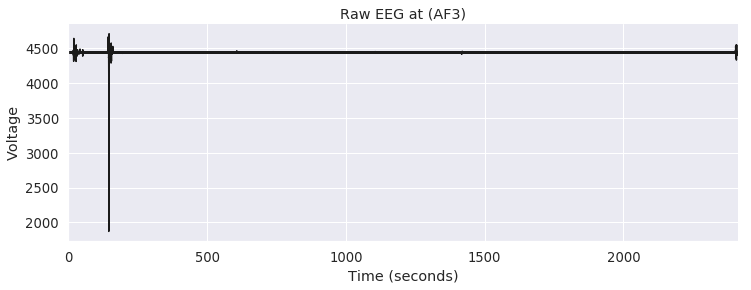

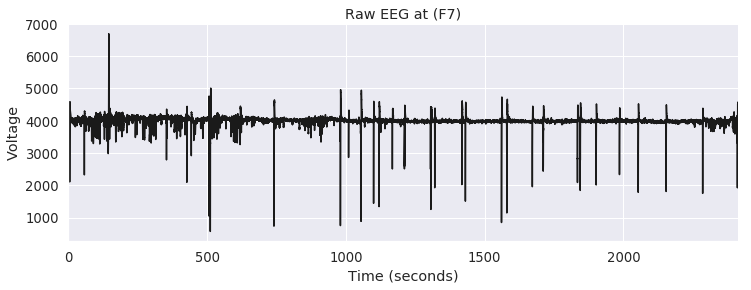

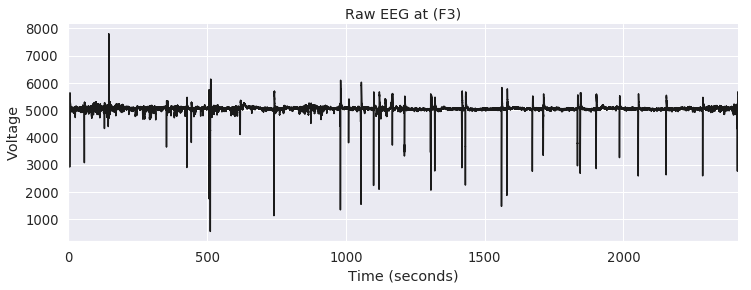

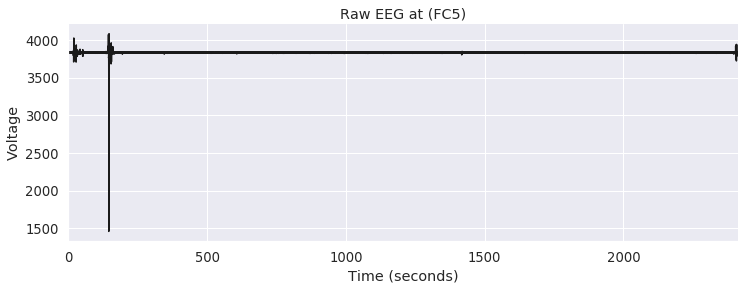

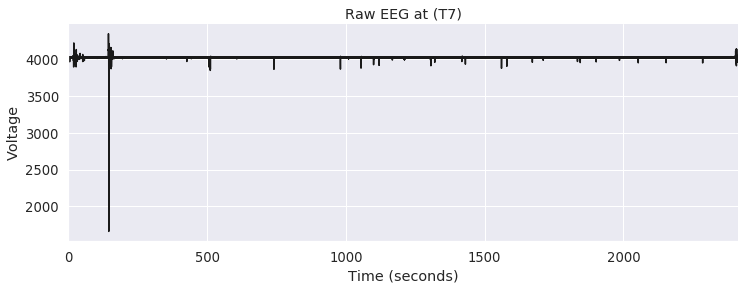

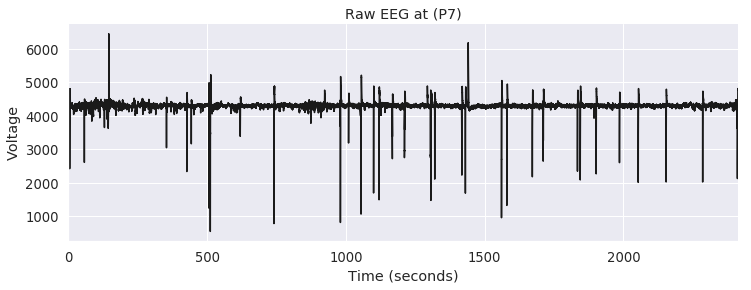

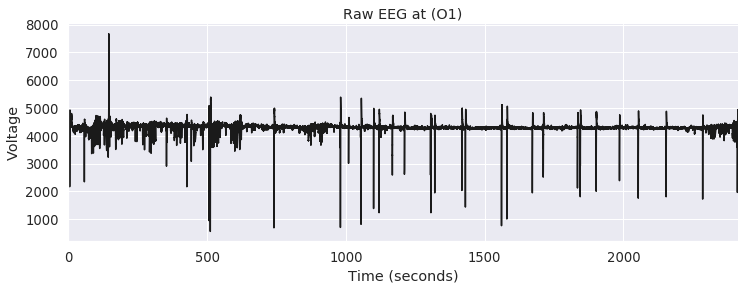

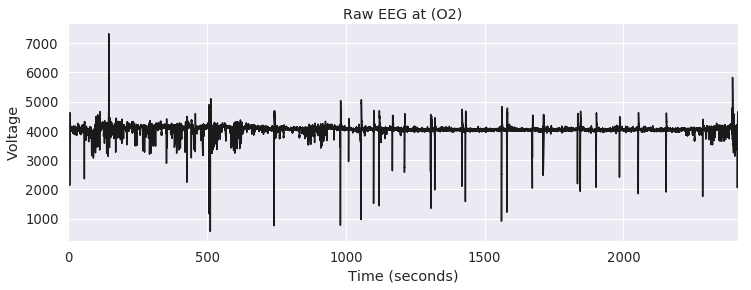

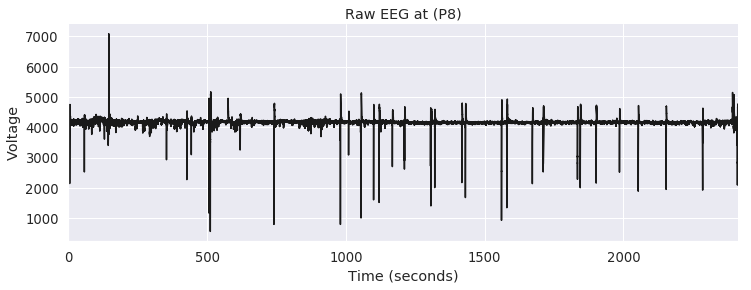

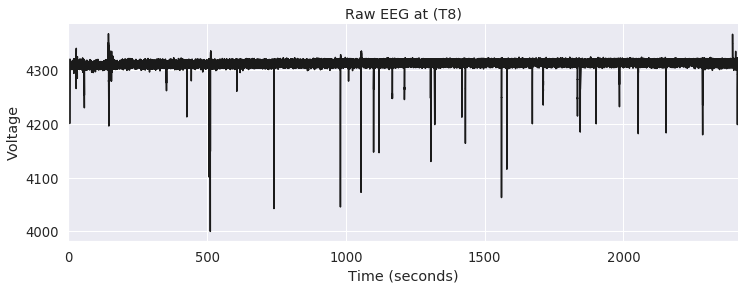

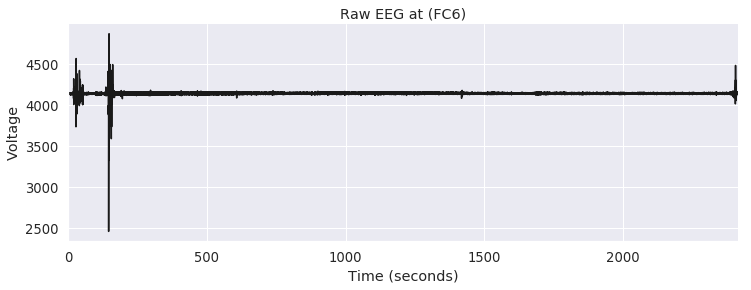

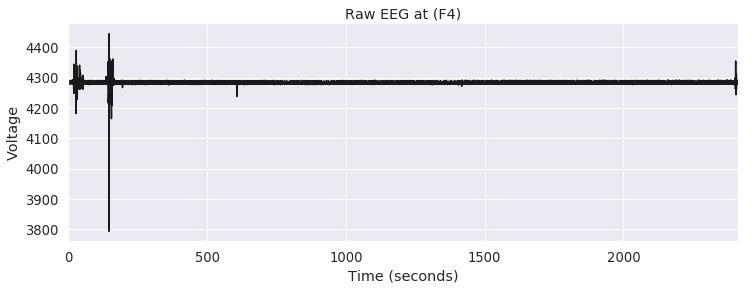

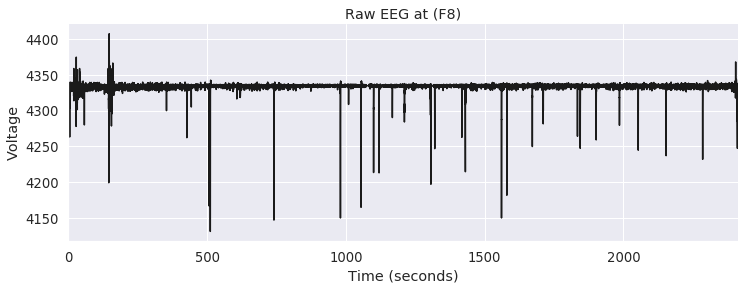

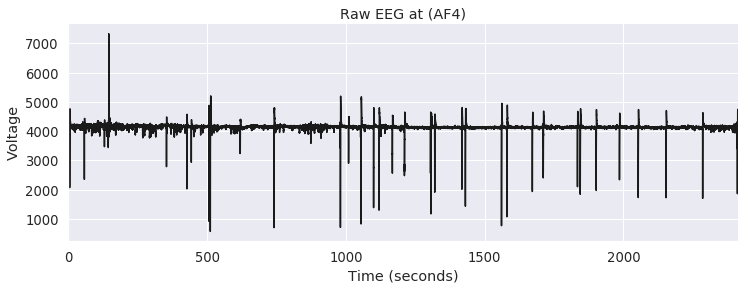

In [3]:
# Define data channels names
data_channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

for idx, val in enumerate(data_channels):
    rawEEGplot(data[:,idx], val)

In [4]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [5]:
# Define the duration of the window to be 4 seconds
win_sec = 4

# Define EEG bands
eeg_bands = {'Delta': [0.5, 4],
             'Theta': [4, 8],
             'Alpha': [8, 12],
             'Beta': [12, 30],
             'Gamma': [30, 100]}

# Compute average absolute power of all bands
def frequencyBands(data):
    return [bandpower(data, sf, band, win_sec) for band in eeg_bands.values()]

# Frequency bands extraction for all channels
channels_features = []
for i in range(14):
    channels_features.append(frequencyBands(data[:,i]))

In [6]:
# Plot the data (using pandas here cause it's easy)
def plotBands(data, channelName):
    sns.set(style="white", font_scale=1.2)
    df = pd.DataFrame(columns=['band', 'val'])
    df['band'] = eeg_bands.keys()
    df['val'] = data
    ax = df.plot.bar(figsize=(12, 8), x='band', y='val', legend=False)
    ax.set_xlabel("EEG band of (" + channelName + ") channel")
    ax.set_ylabel("Mean band Amplitude")

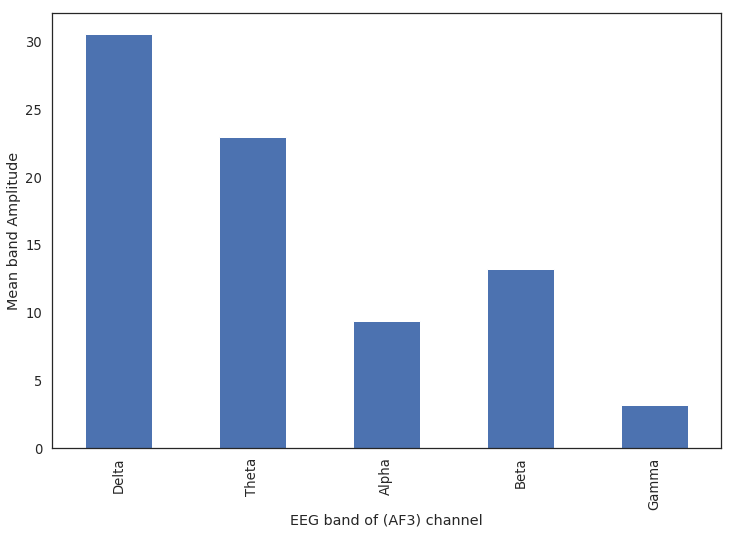

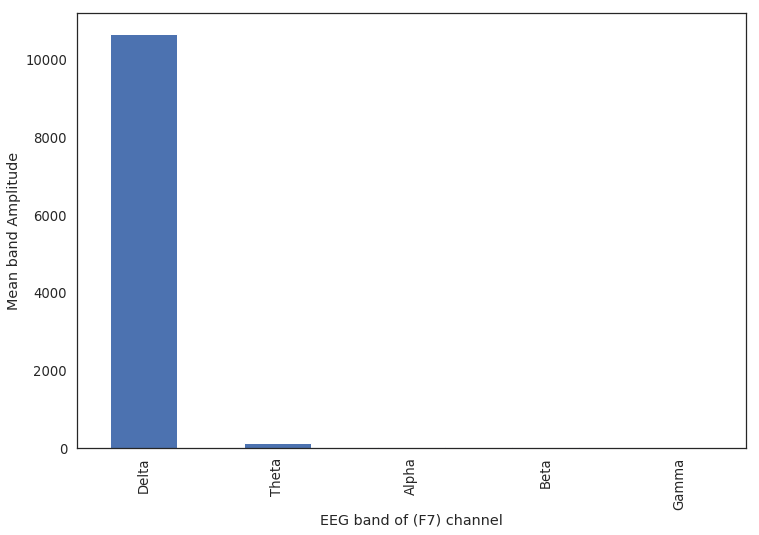

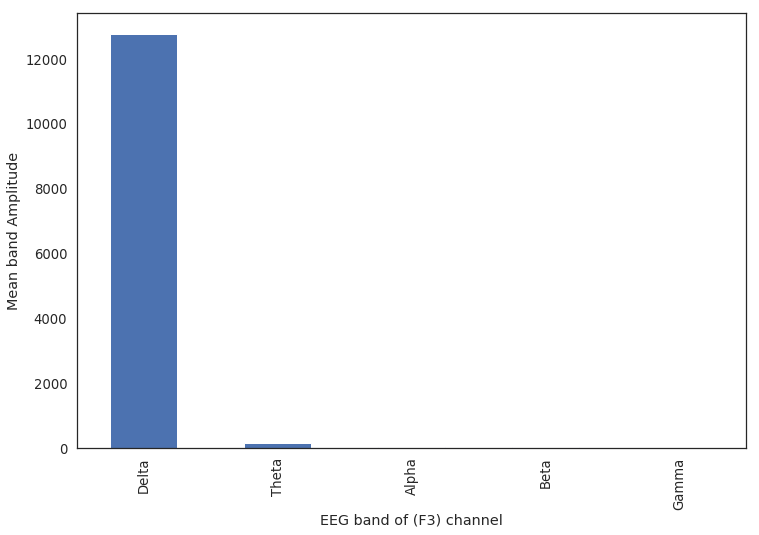

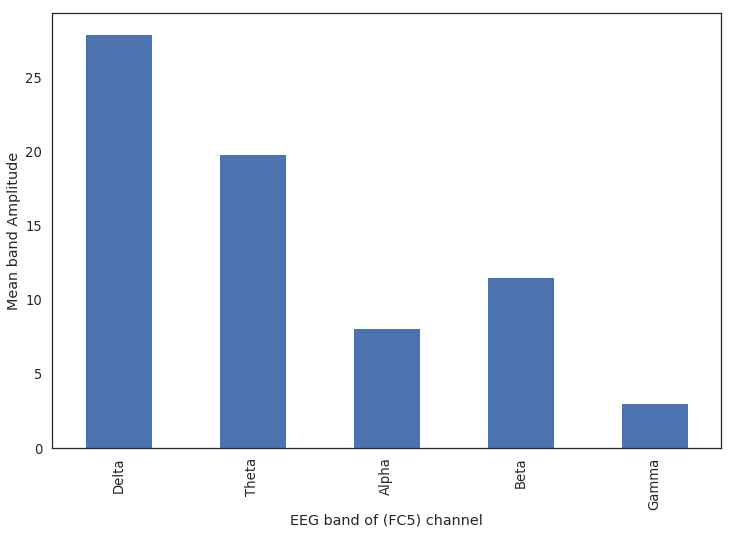

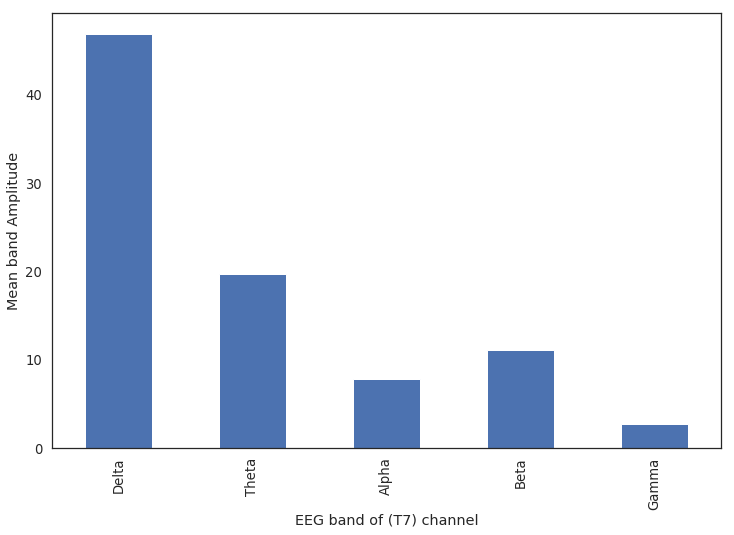

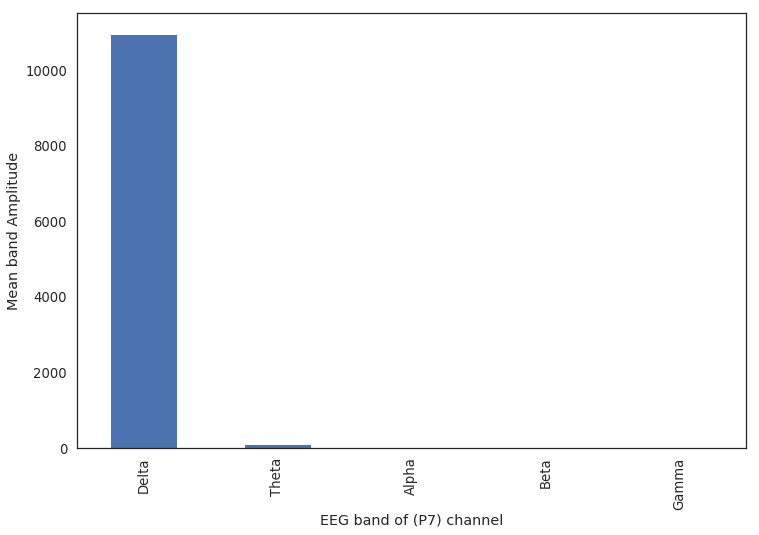

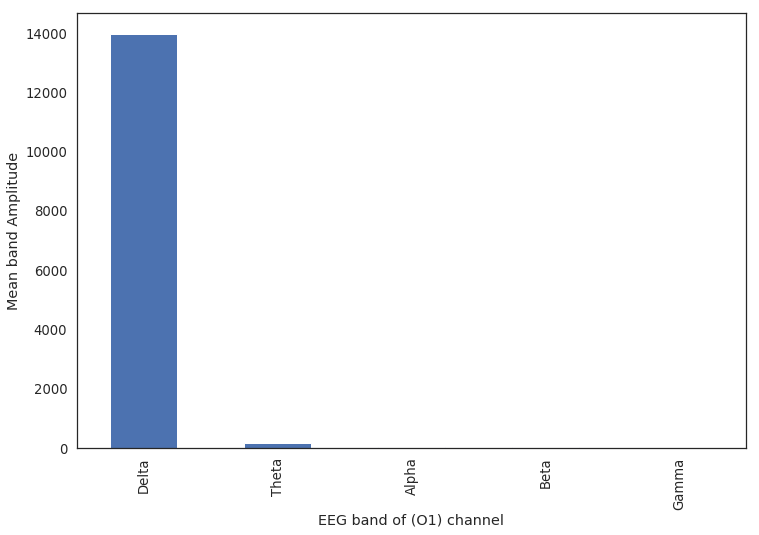

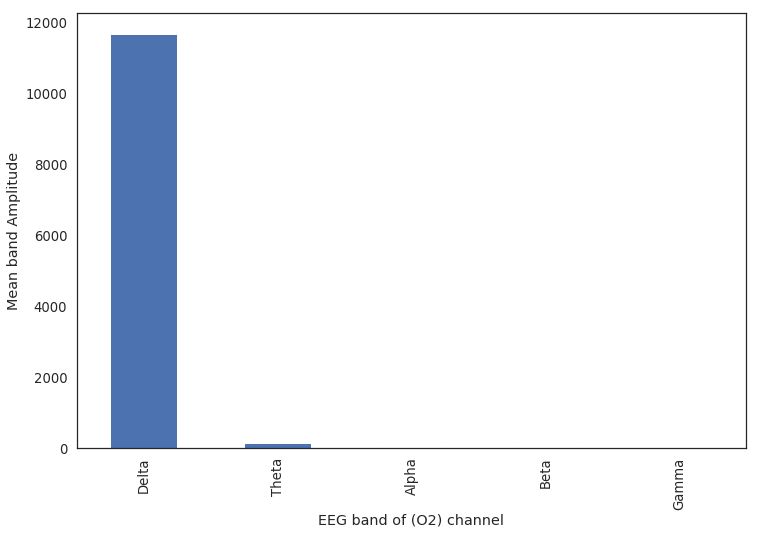

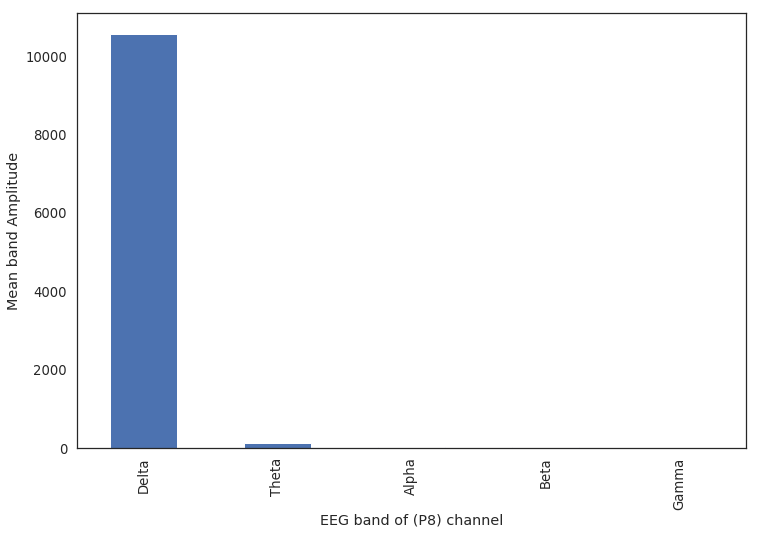

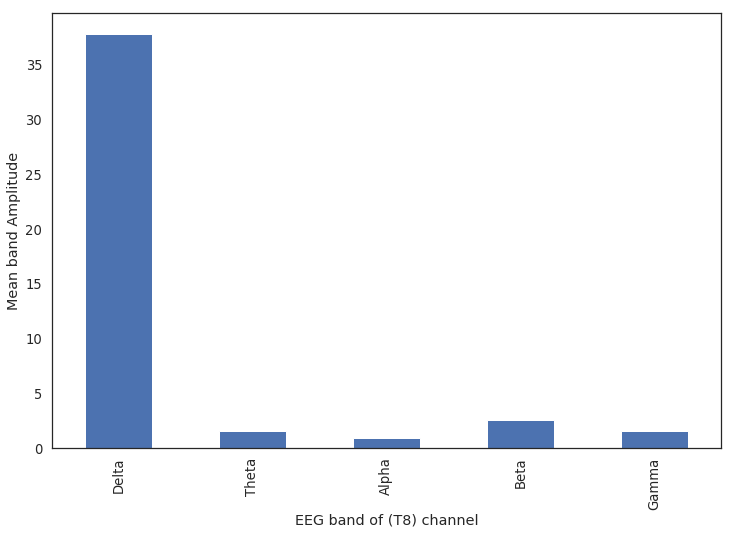

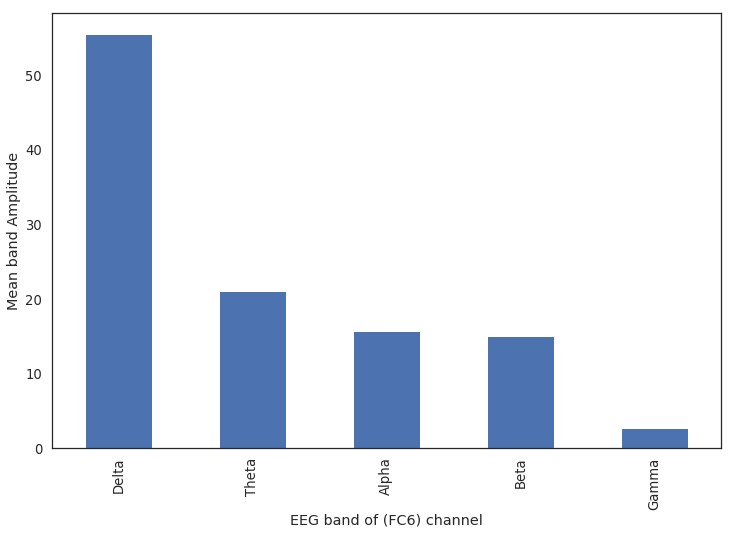

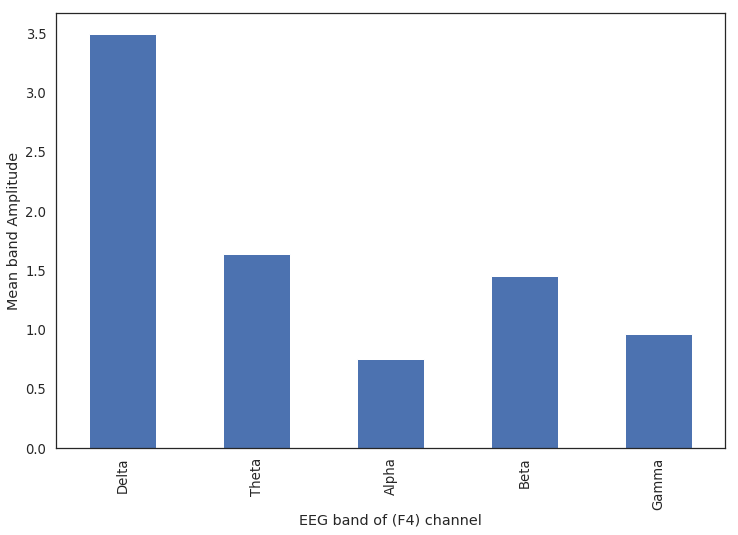

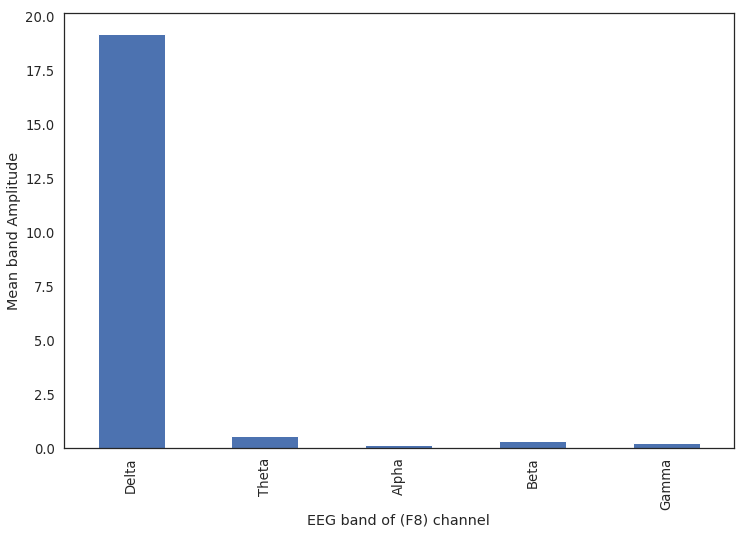

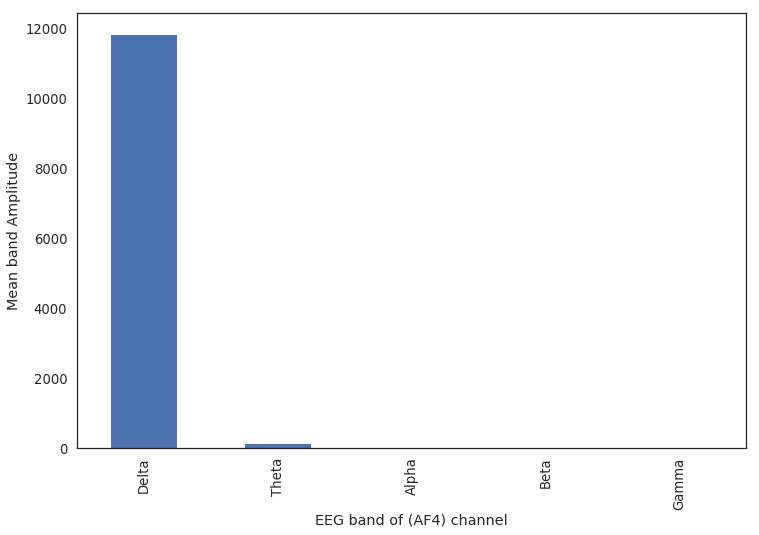

In [7]:
# Full polt of all channels frequency bands
for idx, val in enumerate(data_channels):
    plotBands(channels_features[idx], val)